In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df_Clients_Accounts = pd.read_excel("data/Analytics Showdown Data (Koolboks).xlsx",sheet_name="Clients_Accounts")
df_Payments = pd.read_excel("data/Analytics Showdown Data (Koolboks).xlsx",sheet_name="Payments")

In [3]:
from code.feature_engineer import FeatureEngineer 

 # Create an instance of FeatureEngineer
FeatureEngineer = FeatureEngineer()

# Apply feature engineering using the main function
df_model = FeatureEngineer.transform(df_Clients_Accounts,df_Payments)

c:\Users\anson\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\anson\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [4]:
FeatureEngineer.numerical_feature

['down_payment',
 'down_payment_days_included',
 'minimum_payment',
 'full_price',
 'payment_amount_per_period',
 'payment_period_in_days',
 'nominal_term_days',
 'total_paid',
 'mean_income',
 'age',
 'num_payment_term',
 'max_payment_list',
 'mean_payment_list']

In [5]:
FeatureEngineer.categorical_feature

['product_size',
 'state',
 'gender',
 'occupation',
 'business_type',
 'business_size',
 'lead_source',
 'product_use',
 'registration_date_year',
 'registration_date_month',
 'registration_date_weekday',
 'latest_payment_date_year',
 'latest_payment_date_month',
 'latest_payment_date_weekday',
 'geo_cluster']

In [6]:
FeatureEngineer.target

{'target1': 'default_ratio', 'target2': 'default'}

In [31]:
df_model.isna().sum()

down_payment                      0
down_payment_days_included      191
minimum_payment                   0
full_price                        0
payment_amount_per_period         0
payment_period_in_days          191
nominal_term_days                 0
total_paid                        0
mean_income                     361
age                             962
num_payment_term                  2
max_payment_list                  2
mean_payment_list                 2
product_size                      0
state                             1
gender                          103
occupation                      626
business_type                   279
business_size                  1253
lead_source                    1569
product_use                    1410
registration_date_year            0
registration_date_month           0
registration_date_weekday         0
latest_payment_date_year          2
latest_payment_date_month         2
latest_payment_date_weekday       2
geo_cluster                 

# Classification Model

In [7]:
%matplotlib inline
np.set_printoptions(precision=3)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, make_scorer

In [21]:
X = df_model.drop(["default_ratio","default"], axis=1)
y = df_model["default"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,y_train_val, test_size=0.2, random_state=0)

pipe_cat = make_pipeline( SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown="ignore"))
pipe_num = make_pipeline(SimpleImputer())
preprocessor = make_column_transformer( (pipe_cat, FeatureEngineer.categorical_feature),
                                        (pipe_num, FeatureEngineer.numerical_feature) )

from sklearn.ensemble import RandomForestClassifier

pipe_rf = make_pipeline(preprocessor, RandomForestClassifier())

np.set_printoptions(precision=6, suppress=True)
param_grid = {'randomforestclassifier__max_features': [2,4,6,8,10],
              'randomforestclassifier__max_depth': [6,8,10,12,14]}
param_grid

# Define F1 score as the evaluation metric
f1_scorer = make_scorer(f1_score, average='micro')

grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid, cv=5, scoring=f1_scorer, return_train_score=True)
grid_rf.fit(X_train_val, y_train_val)

print(f"The best parameters on validation set is: {grid_rf.best_params_}")
print("accuracy on test set: %f" % grid_rf.score(X_test, y_test))

{'randomforestclassifier__max_features': [2, 4, 6, 8, 10],
 'randomforestclassifier__max_depth': [6, 8, 10, 12, 14]}

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['product_size',
                                                                          'state',
                                                                          'gender',
                                                                          'occupation',
                                                                          'business_type',
                                                                          'business_size',
                                                                          'lead_source',
                                                                          'product_use',...
                                                                          'nominal_term_days',
                                                                          'total_paid',
                                                                          'mean_income',
                                                                          'age',
                                                                          'num_payment_term',
                                                                          'max_payment_list',
                                                                          'mean_payment_list'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': [6, 8, 10, 12,
                                                               14],
                         'randomforestclassifier__max_features': [2, 4, 6, 8,
                                                                  10]},
             return_train_score=True,
             scoring=make_scorer(f1_score, average=micro))

The best parameters on validation set is: {'randomforestclassifier__max_depth': 14, 'randomforestclassifier__max_features': 10}
accuracy on test set: 0.840659


In [22]:
from sklearn.metrics import classification_report

y_pred = grid_rf.predict(X_test)
# Combined report 
print('Decision tree\n', 
      classification_report(y_test, y_pred, target_names = ['0', '1']))

Decision tree
               precision    recall  f1-score   support

           0       0.83      0.99      0.90       135
           1       0.91      0.43      0.58        47

    accuracy                           0.84       182
   macro avg       0.87      0.71      0.74       182
weighted avg       0.85      0.84      0.82       182



## SMOTE

In [23]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
seed = 1

# Create the function that can use for repetition work
def SMOTE_model(X_train_val,y_train_val):
    # Initialize SMOTE
    smote = SMOTE(random_state=seed)

    # Create a pipeline with SMOTE and preprocessing
    pipe_smote = make_imb_pipeline(preprocessor, smote, RandomForestClassifier(n_jobs=-1))

    # Define F1 score as the evaluation metric
    f1_scorer = make_scorer(f1_score, average='micro')

    # Apply SMOTE and Logistic Regression to generate synthetic samples and train the model
    grid_rf = GridSearchCV(pipe_smote, param_grid=param_grid, cv=5, scoring=f1_scorer, return_train_score=True)
    grid_rf.fit(X_train_val,y_train_val)
    return(grid_rf)

grid_rf = SMOTE_model(X_train_val,y_train_val)

y_pred = grid_rf.predict(X_test)
# Combined report 
print('Decision tree\n', 
      classification_report(y_test, y_pred, target_names = ['0', '1']))

Decision tree
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       135
           1       0.88      0.62      0.73        47

    accuracy                           0.88       182
   macro avg       0.88      0.79      0.82       182
weighted avg       0.88      0.88      0.87       182



## SMOTE with subsampling

In [24]:
# subsampling the subset of target equal to 0 by 70%
percentage = 0.7
def zero_sample(df,target:str,percentage):
    one = df[df[target]==1]
    zero = df[df[target]==0]
    zero = zero.sample(frac = percentage, random_state = seed) 

    df_sample = pd.concat([one, zero], ignore_index=True)

    # Separate features and target
    df2 = df_sample.copy()
    X = df2.drop(["default","default_ratio"], axis=1)
    y = df2[target]
    return(X,y)

X,y = zero_sample(df_model,"default",percentage)

# Perform a stratified split on the target variable
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

grid_rf = SMOTE_model(X_train_val,y_train_val)

y_pred = grid_rf.predict(X_test)
# Combined report 
print('Decision tree\n', 
      classification_report(y_test, y_pred, target_names = ['0', '1']))


Decision tree
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       106
           1       0.82      0.68      0.74        34

    accuracy                           0.89       140
   macro avg       0.86      0.81      0.83       140
weighted avg       0.88      0.89      0.88       140



<Figure size 1000x600 with 0 Axes>

<BarContainer object of 14 artists>

Text(0.5, 0, 'Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Top 10% Feature Importances')

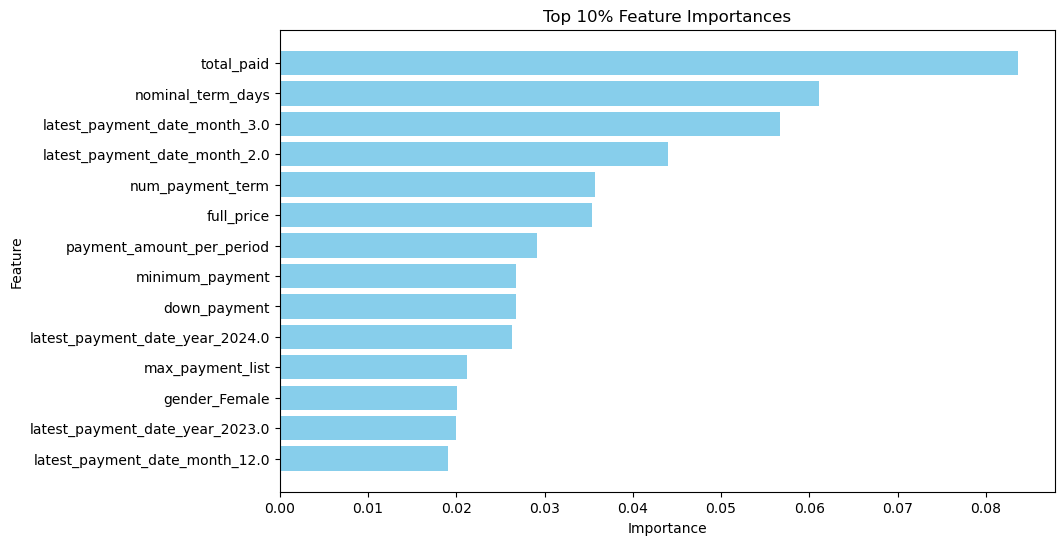

In [25]:
# Get the best estimator from GridSearchCV
best_rf_model = grid_rf.best_estimator_

# Get the fitted preprocessor
fitted_preprocessor = grid_rf.best_estimator_.named_steps['columntransformer']
# Get the fitted OneHotEncoder
fitted_onehot = fitted_preprocessor.named_transformers_['pipeline-1'].\
    named_steps['onehotencoder']
# Get feature names from OneHotEncoder
feature_names = fitted_onehot.get_feature_names_out(FeatureEngineer.categorical_feature)\
    .tolist()
feature_names = feature_names + FeatureEngineer.numerical_feature

# Get feature importances from the best estimator (randomforestclassifier)
feature_importances = best_rf_model.named_steps['randomforestclassifier'].feature_importances_
# Create a DataFrame to store feature names and their importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

num_features_to_keep = int(0.1 * len(importance_df))
top_features = importance_df.iloc[:num_features_to_keep]

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10% Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [28]:
best_rf_model.predict_proba(X_test)[:10]

array([[0.775949, 0.224051],
       [0.673422, 0.326578],
       [0.843847, 0.156153],
       [0.728863, 0.271137],
       [0.647976, 0.352024],
       [0.796452, 0.203548],
       [0.830083, 0.169917],
       [0.822618, 0.177382],
       [0.789914, 0.210086],
       [0.704296, 0.295704]])

# Regression Model

In [15]:
X = df_model.drop(["default_ratio","default"], axis=1)
y = df_model["default_ratio"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,y_train_val, test_size=0.2, random_state=0)

from sklearn.ensemble import RandomForestRegressor

pipe_rf = make_pipeline(preprocessor, RandomForestRegressor())

np.set_printoptions(precision=6, suppress=True)

param_grid = {'randomforestregressor__max_features': [2,4,6,8,10],
              'randomforestregressor__max_depth': [6,8,10,12,14]}

grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
grid_rf.fit(X_train_val, y_train_val)

# The best_score_ will be negative MSE, so take the absolute value and square root
best_rmse = np.sqrt(-grid_rf.best_score_)
print(f'Best RMSE: {best_rmse}')

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['product_size',
                                                                          'state',
                                                                          'gender',
                                                                          'occupation',
                                                                          'business_type',
                                                                          'business_size',
                                                                          'lead_source',
                                                                          'product_use',...
                                                                          'payment_period_in_days',
                                                                          'nominal_term_days',
                                                                          'total_paid',
                                                                          'mean_income',
                                                                          'age',
                                                                          'num_payment_term',
                                                                          'max_payment_list',
                                                                          'mean_payment_list'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [6, 8, 10, 12, 14],
                         'randomforestregressor__max_features': [2, 4, 6, 8,
                                                                 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

Best RMSE: 0.15861569120358407


In [16]:
y_pred = grid_rf.predict(X_test)
result_table = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
result_table

,y_pred,y_test
970,0.132279,0.062500
1145,0.226758,0.273897
1743,0.027607,0.000000
542,0.191620,0.122249
1320,0.275285,0.253478
...,...,...
1334,0.034584,0.000000
1548,0.202750,0.106274
713,0.149731,0.561441
1737,0.196310,0.238612


<Figure size 1000x600 with 0 Axes>

<BarContainer object of 15 artists>

Text(0.5, 0, 'Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Top 10% Feature Importances')

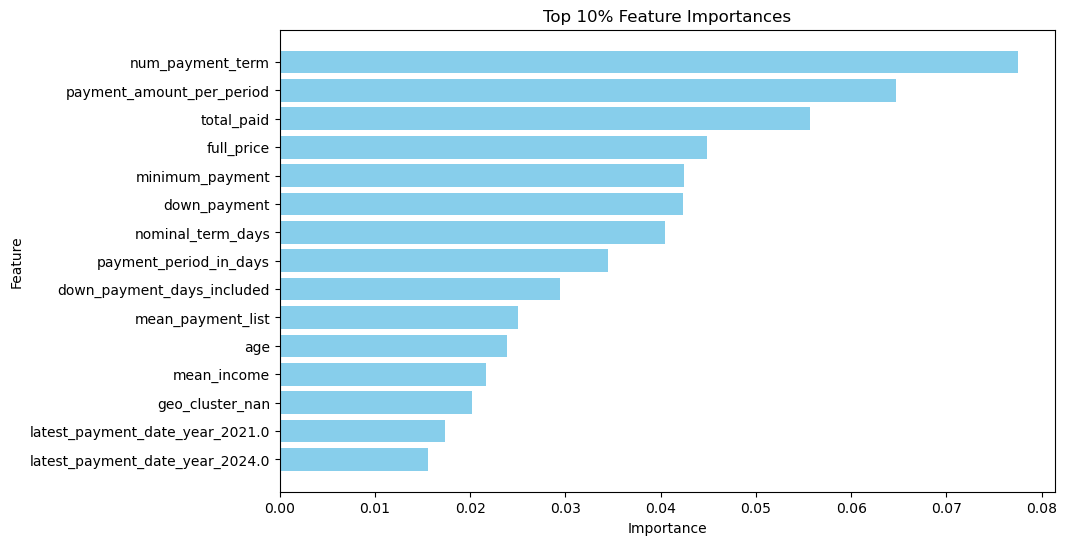

In [17]:
# Get the best estimator from GridSearchCV
best_rf_model = grid_rf.best_estimator_

# Get the fitted preprocessor
fitted_preprocessor = grid_rf.best_estimator_.named_steps['columntransformer']
# Get the fitted OneHotEncoder
fitted_onehot = fitted_preprocessor.named_transformers_['pipeline-1'].\
    named_steps['onehotencoder']
# Get feature names from OneHotEncoder
feature_names = fitted_onehot.get_feature_names_out(FeatureEngineer.categorical_feature)\
    .tolist()
feature_names = feature_names + FeatureEngineer.numerical_feature

# Get feature importances from the best estimator (randomforestregressor)
feature_importances = best_rf_model.named_steps['randomforestregressor'].feature_importances_
# Create a DataFrame to store feature names and their importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

num_features_to_keep = int(0.1 * len(importance_df))
top_features = importance_df.iloc[:num_features_to_keep]

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10% Feature Importances')
plt.gca().invert_yaxis()
plt.show()